In [1]:
from data.soliton_dataset import SolitonDataset
from models.autoencoders import AutoencoderFC, AutoencoderConv1D, AutoencoderRNN
from utils.utils import train_val_test_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

/home/olegnest/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv("df_soliton.csv")
df.head()

,1550.0,1549.8748798925087,1549.7497799834402,1549.624700267904,1549.4996407410108,1549.3746013978732,1549.2495822336057,1549.1245832433235,1548.999604422144,1548.8746457651862,...,1551.1269907041835,1551.0016885905482,1550.8764067194222,1550.751145085901,1550.6259036850813,1550.5006825120613,1550.375481561941,1550.2503008298215,1550.1251403108065,target
0,25.646056,25.650028,25.639966,25.615890,25.577855,25.525948,25.460286,25.381017,25.288318,25.182399,...,24.990649,25.116764,25.230041,25.330229,25.417107,25.490478,25.550179,25.596074,25.628057,cons_one
1,106.806266,112.409808,424.880242,686.914489,1405.909674,32.762638,130.044831,625.502883,1410.410023,115.495991,...,325.588571,138.500308,80.540597,225.456932,649.640334,1.996701,229.406224,761.822174,213.996442,cons_many
2,66.742776,523.683413,317.596944,1046.224701,744.272499,250.673772,426.875556,270.139851,449.280882,289.328584,...,81.704307,349.552649,420.345688,186.359228,363.575276,56.096868,331.010606,199.400477,114.965091,cons_many
3,17.406022,17.368336,17.246741,17.043367,16.761907,16.407466,15.986371,15.505929,14.974164,14.399550,...,14.380802,14.948072,15.474983,15.953217,16.374769,16.732200,17.018902,17.229347,17.359305,cons_one
4,103.739823,103.581529,102.286535,99.899522,96.525690,92.330496,87.533321,82.394103,77.191973,72.194477,...,67.858970,73.340071,78.891431,84.296851,89.358338,93.893959,97.737289,100.739222,102.772649,cons_one


In [4]:
float_columns = sorted(df.columns[:-1])
cols = ["target"]
for col in float_columns:
    if 1520 < float(col) < 1580:
        cols.append(col)
df = df[cols]

In [5]:
df_train, df_val, df_test = train_val_test_split(df, val_size=0.1, test_size=0.1, random_state=SEED)

In [6]:
dim_int = df_train.shape[1] - 1

model = AutoencoderFC(dim_code=dim_int)
# model = AutoencoderConv1D(1)
# model = AutoencoderRNN(dim_int, 1)

In [7]:
if model.__class__.__name__ == "AutoencoderRNN":
    batch_size = 1
else:
    batch_size = 32

scaler = None
# scaler = StandardScaler()

spectra_train = SolitonDataset(df_train, train=True, scaler=scaler)
spectra_val = SolitonDataset(df_val, scaler=scaler)
spectra_test = SolitonDataset(df_test, scaler=scaler)

train_dataloader = DataLoader(spectra_train,batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(spectra_val, batch_size=batch_size)
test_dataloader = DataLoader(spectra_test, batch_size=batch_size)

dataloaders = {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}

In [8]:
criterion = torch.nn.MSELoss()
triplet = torch.nn.TripletMarginLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)

In [9]:
from torch.nn import functional as F
class AngularPenaltySMLoss(nn.Module):

    def __init__(self, in_features, out_features, loss_type="arcface", eps=1e-7, s=None, m=None):
        super(AngularPenaltySMLoss, self).__init__()
        assert loss_type in  ["arcface", "sphereface", "cosface"]
        
        if loss_type == "arcface":
            self.s = 64.0 if not s else s
            self.m = 0.5 if not m else m
        if loss_type == "sphereface":
            self.s = 64.0 if not s else s
            self.m = 1.35 if not m else m
        if loss_type == "cosface":
            self.s = 30.0 if not s else s
            self.m = 0.4 if not m else m
        self.loss_type = loss_type
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.eps = eps

    def forward(self, x, labels):

        for W in self.fc.parameters():
            W = F.normalize(W, p=2, dim=1)

        x = F.normalize(x, p=2, dim=1)

        wf = self.fc(x)
        if self.loss_type == "cosface":
            numerator = self.s * (torch.diagonal(wf.transpose(0, 1)[labels]) - self.m)
        if self.loss_type == "arcface":
            numerator = self.s * torch.cos(torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.m)
        if self.loss_type == "sphereface":
            numerator = self.s * torch.cos(self.m * torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)))

        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)
        L = numerator - torch.log(denominator)
        return -torch.mean(L)

In [14]:
def train(model, dataloaders, optimizer, critrerion, epochs=100, scheduler=None, device=torch.device("cpu")):

    clf = KNeighborsClassifier(n_neighbors=3)
    model = model.to(device)
    scores = {
        "mse_train": [],
        "mse_val": [],
        "arc_loss": [],
        "accuracy_clf": [],
        "silhoutte": [],
    }
    arc = AngularPenaltySMLoss(2, 5, loss_type="arcface", s=10).to(device)

    for epoch in tqdm(range(epochs)):
        train_mse_loss = []
        train_arc_loss = []

        val_mse_loss = []

        arr_label_train = []
        arr_emb_train = []

        arr_label_val = []
        arr_emb_val = []

        model.train()
        for anchor, _, _, anchor_label in dataloaders["train"]:

            anchor = anchor.to(device)
            anchor_label = anchor_label.to(device)
            optimizer.zero_grad()

            anchor_rebuild, anchor_out = model(anchor)
            loss_arc = arc(labels=anchor_label, x=anchor_out)

            loss_mse = critrerion(anchor, anchor_rebuild)
            loss = loss_arc + loss_mse * 0.001
            loss.backward()
            optimizer.step()

            train_mse_loss.append(loss_mse.item())
            train_arc_loss.append(loss_arc.cpu().detach().numpy())
            arr_emb_train.append(anchor_out.cpu().detach().numpy())
            arr_label_train.append(anchor_label.cpu().detach().numpy())

        clf = KNeighborsClassifier(n_neighbors=3)
        emb_train = np.array(arr_emb_train[:-1]).reshape(-1,2)
        label_train = np.array(arr_label_train[:-1]).reshape(-1)
        clf.fit(X=emb_train, y=label_train)

        model.eval()
        for anchor, _, _, anchor_label in dataloaders["val"]:
            anchor = anchor.to(device)
            anchor_label = anchor_label.to(device)
            anchor_rebuild, anchor_out = model(anchor)

            loss_mse_val = critrerion(anchor, anchor_rebuild)
            val_mse_loss.append(loss_mse_val.item())

            arr_emb_val.append(anchor_out.cpu().detach().numpy())
            arr_label_val.append(anchor_label.cpu().detach().numpy())

        emb_test = np.array(arr_emb_val[:-1]).reshape(-1,2)
        label_test = np.array(arr_label_val[:-1]).reshape(-1)
        label_pred = clf.predict(X=emb_test)

        acc = accuracy(label_test, label_pred)
        silhoutte = silhouette_score(X=emb_test, labels=label_test)
        scores["accuracy_clf"].append(acc)
        scores["silhoutte"].append(silhoutte)
        scores["mse_train"].append(np.mean(train_mse_loss))
        scores["mse_val"].append(np.mean(val_mse_loss))
        scores["arc_loss"].append(np.mean(train_arc_loss))
        if scheduler:
            scheduler.step()

        print(f"Epoch #{epoch + 1}: MSE train: {np.mean(train_mse_loss)}, MSE val: {np.mean(val_mse_loss)}\t Arc train: {np.mean(train_arc_loss)} \t Val acc: {acc}")

    return model, scores


In [15]:
m_trained, scores = train(model, dataloaders, optimizer, criterion, 20, scheduler, device=device)

  5%|▌         | 1/20 [00:09<03:09,  9.99s/it]

Epoch #1: MSE train: 2663.8293822439095, MSE val: 2510.238327923943	 Arc train: 6.023303985595703 	 Val acc: 0.541015625


 10%|█         | 2/20 [00:19<02:59,  9.96s/it]

Epoch #2: MSE train: 2541.7088404203714, MSE val: 2283.9848022460938	 Arc train: 6.8853759765625 	 Val acc: 0.79296875


 15%|█▌        | 3/20 [00:30<02:54, 10.24s/it]

Epoch #3: MSE train: 2458.5787729966014, MSE val: 2276.6540132410387	 Arc train: 6.896175861358643 	 Val acc: 0.83203125


 20%|██        | 4/20 [00:41<02:46, 10.39s/it]

Epoch #4: MSE train: 2465.270955939042, MSE val: 2281.0289432301242	 Arc train: 6.8958048820495605 	 Val acc: 0.841796875


 25%|██▌       | 5/20 [00:51<02:35, 10.40s/it]

Epoch #5: MSE train: 2473.3177542435496, MSE val: 2281.3644822064566	 Arc train: 6.8955979347229 	 Val acc: 0.814453125


 30%|███       | 6/20 [01:01<02:25, 10.42s/it]

Epoch #6: MSE train: 2461.7162551879883, MSE val: 2281.356861787684	 Arc train: 6.894443035125732 	 Val acc: 0.814453125


 35%|███▌      | 7/20 [01:12<02:15, 10.41s/it]

Epoch #7: MSE train: 2457.7590142300255, MSE val: 2281.3563106761258	 Arc train: 6.894505500793457 	 Val acc: 0.83984375


 40%|████      | 8/20 [01:22<02:04, 10.38s/it]

Epoch #8: MSE train: 2456.9026039525083, MSE val: 2281.3562873391543	 Arc train: 6.894688606262207 	 Val acc: 0.833984375


 45%|████▌     | 9/20 [01:32<01:53, 10.28s/it]

Epoch #9: MSE train: 2453.96069817794, MSE val: 2281.3562873391543	 Arc train: 6.895230770111084 	 Val acc: 0.82421875


 50%|█████     | 10/20 [01:42<01:41, 10.19s/it]

Epoch #10: MSE train: 2465.281959734465, MSE val: 2281.3562873391543	 Arc train: 6.894773006439209 	 Val acc: 0.841796875


 55%|█████▌    | 11/20 [01:52<01:31, 10.19s/it]

Epoch #11: MSE train: 2454.833035318475, MSE val: 2281.3562873391543	 Arc train: 6.8939208984375 	 Val acc: 0.873046875


 60%|██████    | 12/20 [02:03<01:23, 10.38s/it]

Epoch #12: MSE train: 2453.943678805703, MSE val: 2281.3562873391543	 Arc train: 6.893509864807129 	 Val acc: 0.869140625


 65%|██████▌   | 13/20 [02:15<01:15, 10.75s/it]

Epoch #13: MSE train: 2455.1753969694437, MSE val: 2281.3562873391543	 Arc train: 6.894449234008789 	 Val acc: 0.8515625


 70%|███████   | 14/20 [02:27<01:07, 11.25s/it]

Epoch #14: MSE train: 2462.295725571482, MSE val: 2281.3562873391543	 Arc train: 6.894529819488525 	 Val acc: 0.845703125


 75%|███████▌  | 15/20 [02:40<00:57, 11.58s/it]

Epoch #15: MSE train: 2462.2566662838585, MSE val: 2281.3562873391543	 Arc train: 6.894588947296143 	 Val acc: 0.83984375


 80%|████████  | 16/20 [02:51<00:46, 11.57s/it]

Epoch #16: MSE train: 2458.179080561588, MSE val: 2281.3562873391543	 Arc train: 6.893558025360107 	 Val acc: 0.845703125


 85%|████████▌ | 17/20 [03:04<00:35, 11.83s/it]

Epoch #17: MSE train: 2466.4186630249023, MSE val: 2281.3562873391543	 Arc train: 6.894855499267578 	 Val acc: 0.841796875


 90%|█████████ | 18/20 [03:15<00:23, 11.84s/it]

Epoch #18: MSE train: 2462.347925688091, MSE val: 2281.3562873391543	 Arc train: 6.893703937530518 	 Val acc: 0.837890625


 95%|█████████▌| 19/20 [03:27<00:11, 11.83s/it]

Epoch #19: MSE train: 2454.8620221991287, MSE val: 2281.3562873391543	 Arc train: 6.895021915435791 	 Val acc: 0.841796875


100%|██████████| 20/20 [03:39<00:00, 10.97s/it]

Epoch #20: MSE train: 2462.8392247651755, MSE val: 2281.3562873391543	 Arc train: 6.894573211669922 	 Val acc: 0.845703125


In [16]:
train_results = []
labels = []

model.eval()
for img, _, _, label in tqdm(dataloaders["test"]):
    _, emb = model(img.to(device))
    train_results.append(emb.detach().numpy())
    labels.append(label)

train_results = np.concatenate(train_results)
labels = np.concatenate(labels)

100%|██████████| 19/19 [00:00<00:00, 49.79it/s]


Text(0.5, 1.0, 'Embeddings after encoding with Arc loss')

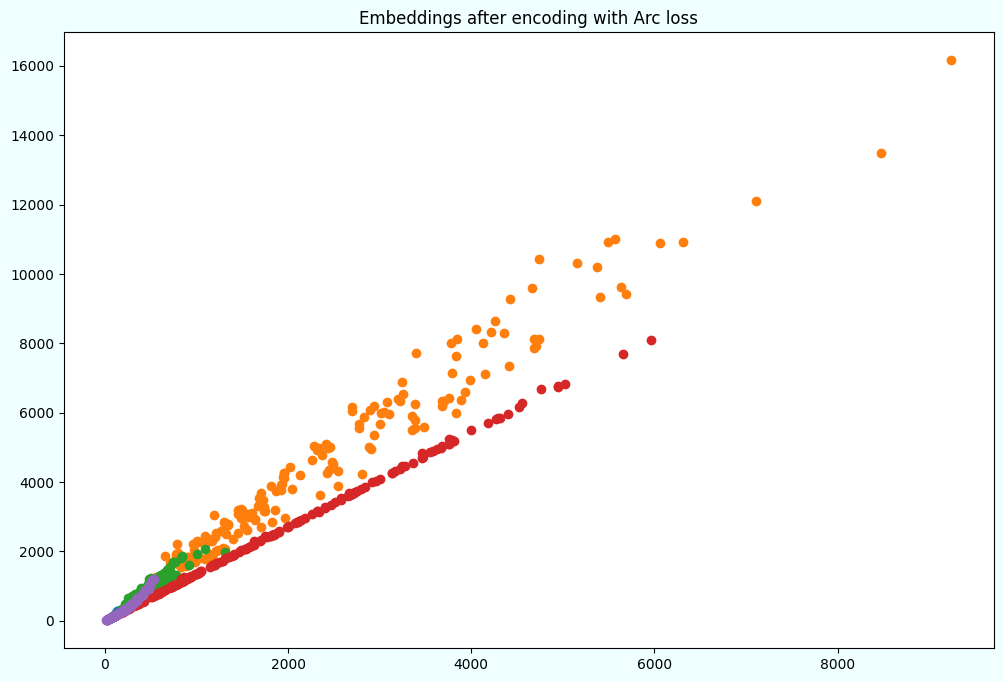

In [17]:
plt.figure(figsize=(12, 8), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1])
plt.title("Embeddings after encoding with Arc loss")